# Variational AutoEncoder

Task: Implement and train a probabilistic AutoEncoder called Variational AutoEncoder (VAE) on MNIST. A nice introduction to this topic is [here](https://www.jeremyjordan.me/variational-autoencoders/).

In [2]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(device)

batch_size = 10

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 0.001 # TODO

epochs = 5 # TODO

cpu


In [4]:
dataset_path = 'datasets'
mnist_transform = torchvision.transforms.Compose([ torchvision.transforms.ToTensor() ]) 
torchvision.datasets.MNIST.__len__ = lambda _ : 10
train_dataset = torchvision.datasets.MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [5]:
# Implement Encoder that consists of FC input_dim -> hidden_dim, FC hidden_dim -> hidden_dim, FC hidden_dim -> latent_dim
# You can use LeakyReLU 0.2

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_mu= nn.Linear(hidden_dim, latent_dim)

        self.lrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.lrelu(self.fc1(x))
        x = self.ln1(x)

        x = self.lrelu(self.fc2(x))
        x = self.ln2(x)

        # x = self.fc3(x)

        return self.fc_mu(x), self.fc_logvar(x)

In [6]:
# Implement Decoder that consists of FC latent_dim -> hidden_dim, FC hidden_dim -> hidden_dim, FC hidden_dim -> output_dim
# You can use Sigmoid and LeakyReLU 0.2

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.lrelu = nn.LeakyReLU(0.2)
        self.sigm = nn.Sigmoid()
        
    def forward(self, x):
        x = self.lrelu(self.fc1(x))
        x = self.ln1(x)

        x = self.lrelu(self.fc2(x))
        x = self.ln2(x)

        x = self.fc3(x)

        return self.sigm(x)

In [7]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder, latent_dim):
        super(Model, self).__init__()
        self.latent_dim = latent_dim
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, logvar):
        stddev = torch.exp(0.5 * logvar)
        eps = torch.randn_like(stddev)

        return eps * stddev + mean 
        # return stddev + mean 
                
    def forward(self, x):
        x_clone = x.clone()

        x_mu, x_logvar = self.Encoder(x)

        # x_logvar = x[:, :self.latent_dim]
        # x_mu = x[:, self.latent_dim:]

        assert x_logvar.shape == x_mu.shape, (x_logvar.shape, x_mu.shape)
        
        x = self.reparameterization(x_mu, x_logvar)

        x = self.Decoder(x)

        return x_clone, x, x_mu, x_logvar 

In [12]:
latent_dim = int(200 / 2)

print(x_dim, hidden_dim, latent_dim)

encoder = Encoder(
    input_dim = x_dim,
    hidden_dim = hidden_dim,
    latent_dim = latent_dim,
)

decoder = Decoder(
    latent_dim = latent_dim,
    hidden_dim = hidden_dim,
    output_dim = x_dim,
)

model = Model(Encoder = encoder, Decoder = decoder, latent_dim = latent_dim).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

print([p[0] for p in model.named_parameters()])

784 400 100
['Encoder.fc1.weight', 'Encoder.fc1.bias', 'Encoder.ln1.weight', 'Encoder.ln1.bias', 'Encoder.fc2.weight', 'Encoder.fc2.bias', 'Encoder.ln2.weight', 'Encoder.ln2.bias', 'Encoder.fc_logvar.weight', 'Encoder.fc_logvar.bias', 'Encoder.fc_mu.weight', 'Encoder.fc_mu.bias', 'Decoder.fc1.weight', 'Decoder.fc1.bias', 'Decoder.ln1.weight', 'Decoder.ln1.bias', 'Decoder.fc2.weight', 'Decoder.fc2.bias', 'Decoder.ln2.weight', 'Decoder.ln2.bias', 'Decoder.fc3.weight', 'Decoder.fc3.bias']


In [8]:
# Loss function for the Gaussian distribution prior is presented in https://arxiv.org/pdf/1907.08956.pdf, Eq. 43.
def cross_entropy(x, x_hat):
    assert x.shape == x_hat.shape

    len = x.shape[0]

    ce = (-1/len) * torch.sum(x * torch.log(x_hat) + (1 - x) * torch.log(1 - x_hat), dim = 1)

    ce = torch.mean(ce)

    return ce

def loss_function(x, x_hat, mu, logvar, iter = 0):
    kld_weight = 1
    rl_weight = 15

    # recons_loss = cross_entropy(x, x_hat)
    recons_loss = torch.nn.functional.mse_loss(x, x_hat)
    recons_loss *= rl_weight

    KLD = torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1)
    KLD = torch.mean(-0.5 * KLD, dim = 0)
    KLD *= kld_weight

    if iter % 60 == 0:
        print(f'{recons_loss=} {KLD=}')

    return rl_weight * recons_loss #+ kld_weight * KLD

    # def ts:
        # return torch.sum(x)
    # print(ts(logvar.exp()))
    # print(ts(mu ** 2))
    # print(ts(logvar))

In [9]:
def show_images(x, n_samples = 3, x_hat = None):
    x = x.view(batch_size, 28, 28) 
    for i in range(n_samples):
        plt.figure()

        if x_hat is None:
            idx = i
        else:
            idx = torch.rand() * (batch_size - 1)
            idx = int(idx)
            plt.imshow(x_hat[idx].cpu().numpy())

        plt.imshow(x[idx].cpu().numpy())

In [10]:
model.train()
epochs = 200

for epoch in range(epochs):
    overall_loss = 0
    for i, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()

        x, x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var, iter = i)

        # if (i % 70 == 0):
            # print(f'{loss=}')

        # if (i == 0):
            # show_images(x, 1)
            # show_images(x_hat.detach(), 1)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "Average Loss: ", overall_loss / (len(train_loader) * batch_size))

recons_loss=tensor(3.7584, grad_fn=<MulBackward0>) KLD=tensor(25.3170, grad_fn=<MulBackward0>)
	Epoch 1 Average Loss:  5.637540435791015
recons_loss=tensor(3.3985, grad_fn=<MulBackward0>) KLD=tensor(44.2434, grad_fn=<MulBackward0>)
	Epoch 2 Average Loss:  5.097714233398437
recons_loss=tensor(2.6674, grad_fn=<MulBackward0>) KLD=tensor(63.0341, grad_fn=<MulBackward0>)
	Epoch 3 Average Loss:  4.001058197021484
recons_loss=tensor(2.0383, grad_fn=<MulBackward0>) KLD=tensor(84.3025, grad_fn=<MulBackward0>)
	Epoch 4 Average Loss:  3.057377052307129
recons_loss=tensor(1.6035, grad_fn=<MulBackward0>) KLD=tensor(108.4692, grad_fn=<MulBackward0>)
	Epoch 5 Average Loss:  2.405279541015625
recons_loss=tensor(1.3042, grad_fn=<MulBackward0>) KLD=tensor(133.5033, grad_fn=<MulBackward0>)
	Epoch 6 Average Loss:  1.9562566757202149
recons_loss=tensor(1.1120, grad_fn=<MulBackward0>) KLD=tensor(157.4939, grad_fn=<MulBackward0>)
	Epoch 7 Average Loss:  1.6679767608642577
recons_loss=tensor(0.9843, grad_fn=<

In [11]:
model.eval()

with torch.no_grad():
    for i, (x, _) in enumerate(test_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        x, x_hat, _, _ = model(x)
        break

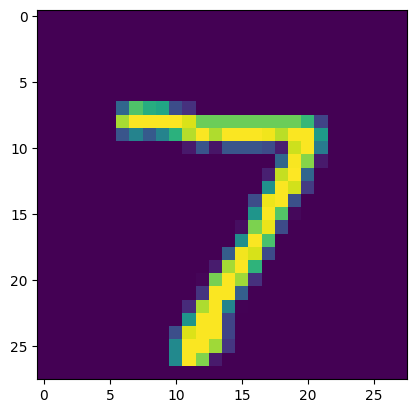

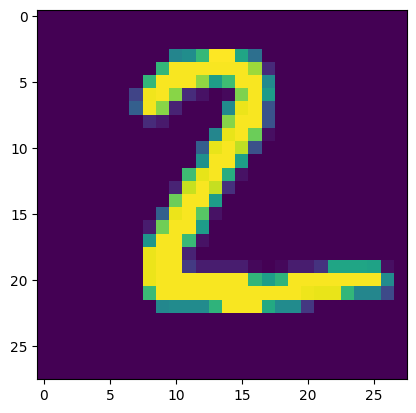

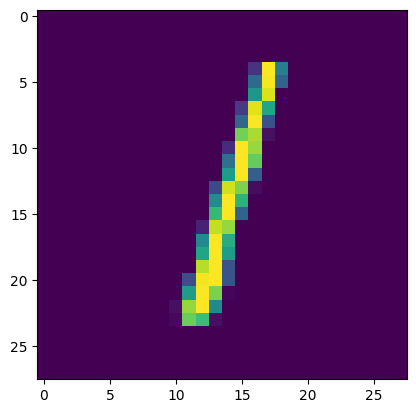

In [12]:
show_images(x)

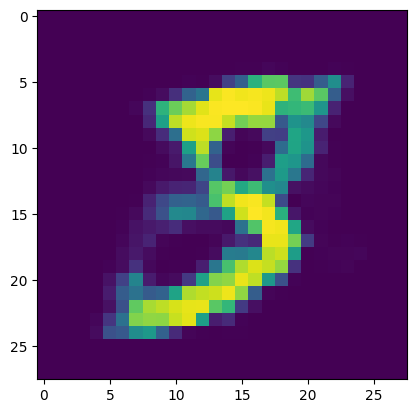

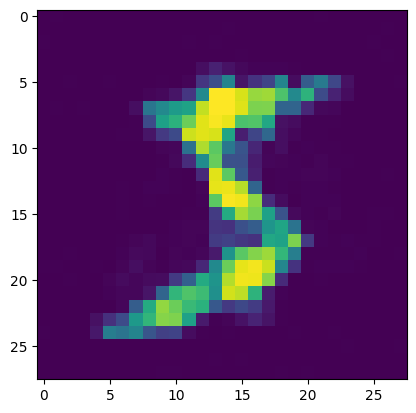

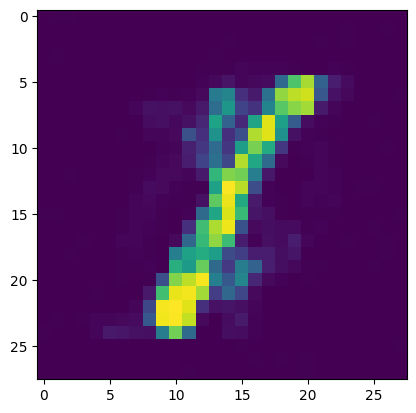

In [13]:
show_images(x_hat)

In [14]:
# TODO: sample noise, generate new images from noise and show generted images